In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

# Constants

In [3]:
DATA_DIR = "classification_data_HWK1/"
COLS = ["red", "blue","green", "orange", "black", "cyan"]
MARKS = ["^","+","*","o","x","."]

# Data

In [4]:
D = {}
for l in "ABC":
    D[l] = {}
    for t in ["train", "test"]:
        D[l][t] = pd.read_csv(DATA_DIR + "classification" + l + "." + t, sep = "\t", names = ["x1", "x2", "y"])

In [5]:
D['A']['train'].as_matrix()

array([[-3.60340505,  1.3266    ,  1.        ],
       [-4.2190114 ,  2.015     ,  1.        ],
       [-1.51565812,  0.5059    ,  1.        ],
       [-1.16975695,  0.3815    ,  1.        ],
       [ 0.52274116, -0.6572    ,  1.        ],
       [-0.14174035, -0.7083    ,  1.        ],
       [-3.2644966 ,  1.312     ,  1.        ],
       [-1.7093627 ,  0.2236    ,  1.        ],
       [-2.06451872,  0.6392    ,  1.        ],
       [-2.7745778 ,  1.139     ,  1.        ],
       [-4.4637327 ,  1.2861    ,  1.        ],
       [-2.05557939,  0.716     ,  1.        ],
       [-4.93081485,  1.9442    ,  1.        ],
       [-2.78573378,  0.8165    ,  1.        ],
       [-3.78492412,  1.0945    ,  1.        ],
       [-0.023503  , -0.1801    ,  1.        ],
       [-4.0787268 ,  1.6789    ,  1.        ],
       [-4.88879174,  2.2006    ,  1.        ],
       [-4.11260798,  1.3405    ,  1.        ],
       [-5.11303227,  1.578     ,  1.        ],
       [-2.76271871,  0.6868    ,  1.   

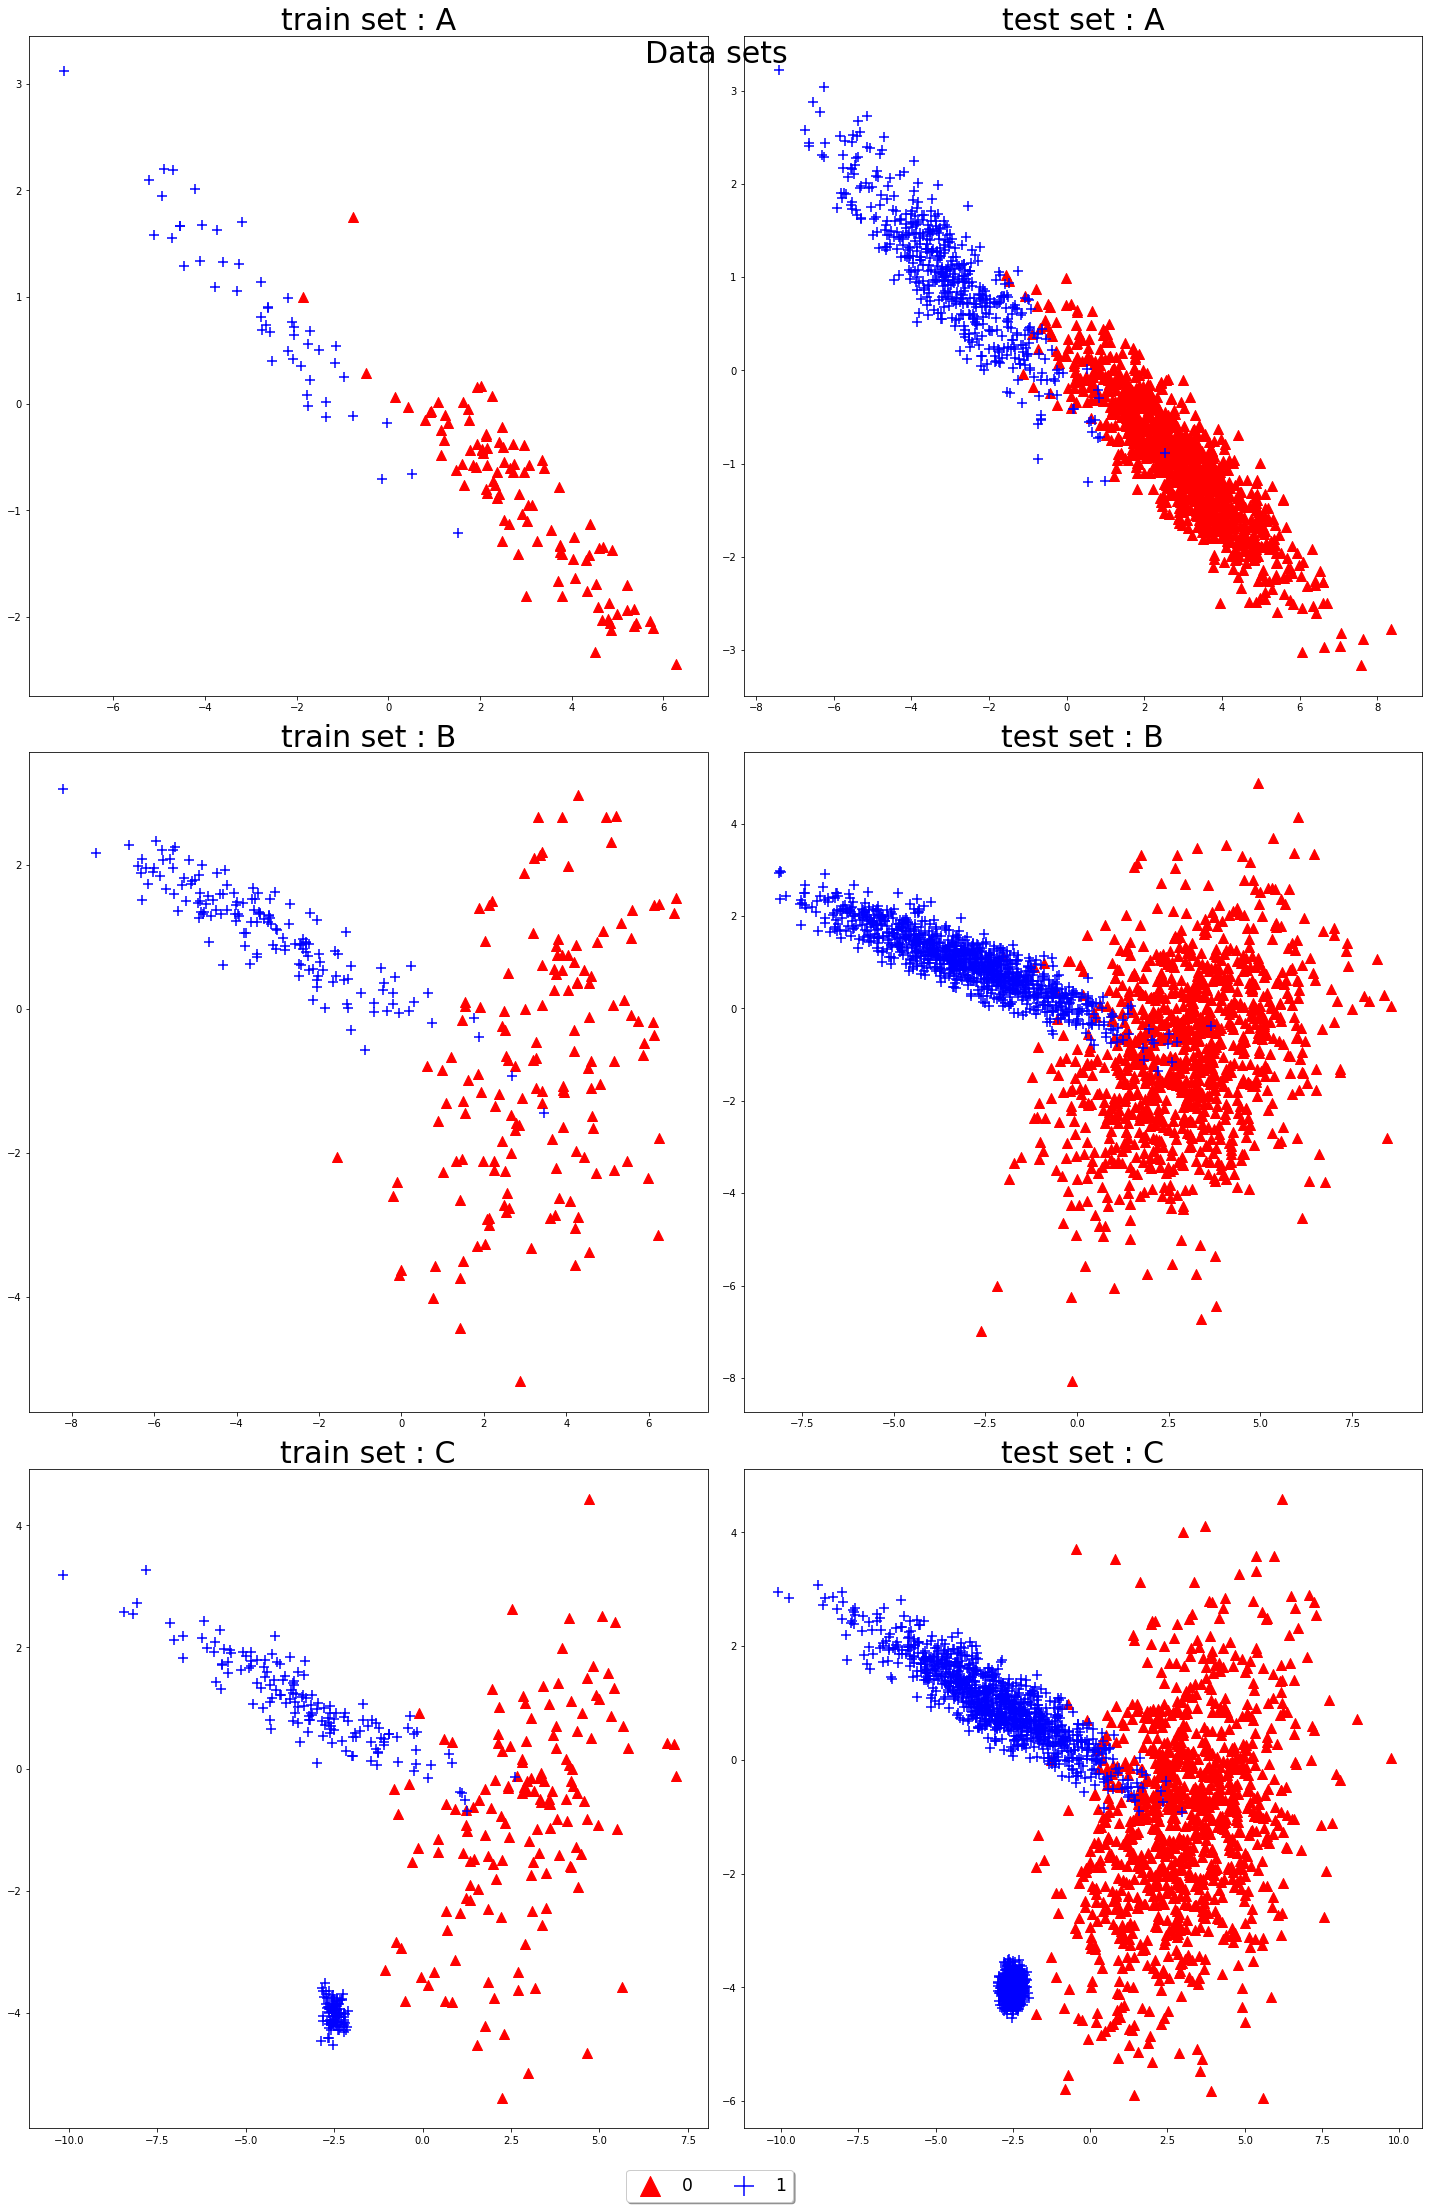

In [6]:
f, ax = plt.subplots(3, 2, figsize = (20, 30))

for k, l in enumerate("ABC"):
    for j, t in enumerate(["train", "test"]):
        x = D[l][t].as_matrix()[:, :2]
        y = D[l][t].as_matrix()[:, 2]
        for i, label in enumerate([0, 1]):
            ax[k][j].scatter(x[y == label, 0], x[y == label, 1],
                             c = COLS[i], marker=MARKS[i],s = 100, label = label)
            ax[k][j].set_title(t + " set : " + l, size = 30);
#             ax[k][j].legend(fontsize = 30);

ax[k][j].legend(loc='upper center', bbox_to_anchor=(-0.05, -0.05),
          fancybox=True, shadow=True, ncol=2, fontsize = 'xx-large', markerscale = 2)
f.suptitle("Data sets", fontsize = 30)
f.tight_layout();

# Plot tools

In [8]:
def make_grid(data=None,xmin=-5,xmax=5,ymin=-5,ymax=5,step=20):
    """ Cree une grille sous forme de matrice 2d de la liste des points
    :param data: pour calcluler les bornes du graphe
    :param xmin: si pas data, alors bornes du graphe
    :param xmax:
    :param ymin:
    :param ymax:
    :param step: pas de la grille
    :return: une matrice 2d contenant les points de la grille
    """
    if data is not None:
        xmax, xmin, ymax, ymin = np.max(data[:,0]),  np.min(data[:,0]), np.max(data[:,1]), np.min(data[:,1])
    x, y =np.meshgrid(np.arange(xmin,xmax,(xmax-xmin)*1./step), np.arange(ymin,ymax,(ymax-ymin)*1./step))
    grid=np.c_[x.ravel(),y.ravel()]
    return grid, x, y

def plot_data(data, labels = None):
    """
    Affiche des donnees 2D
    :param data: matrice des donnees 2d
    :param labels: vecteur des labels (discrets)
    :return:
    """
    cols,marks = ["red", "blue","green", "orange", "black", "cyan"],[".","+","*","o","x","^"]
    if labels is None:
        plt.scatter(data[:,0],data[:,1], c='r',  marker="x")
        return
    for i,l in enumerate(sorted(list(set(labels.flatten())))):
        plt.scatter(data[labels==l,0],data[labels==l,1],c=cols[i],marker=marks[i])
        
def plot_frontiere(data, f, step = 200):
    """ Trace un graphe de la frontiere de decision de f
    :param data: donnees
    :param f: fonction de decision
    :param step: pas de la grille
    :return:
    """
    grid,x, y = make_grid(data = data, step = step)
    plt.contourf(x, y, f(grid).reshape(x.shape), colors=('gray', 'blue'), levels=[-1,0,1], alpha=0.3)

# Class

## LDA

In [9]:
def Quadratic(datax, mu, sigma):
    """
    Compute the quadratic argument of gausisan density
    """

    return -0.5 * np.dot(np.dot((datax - mu), np.linalg.inv(sigma)), (datax - mu).T)
    

class LDA(object):
    """
    LDA class for binary (0, 1) classification
    """
    def __init__(self):
        self.pi = None
        self.mu_0 = None
        self.mu_1 = None
        self.sigma = None
        return
    def fit(self, datax, datay):
        """
        Compute the MLE of for LDA
        """
        # Length of examples
        N = len(datax)
        # Number of class one
        A = datay.sum()
        # Compute pi MLE
        self.pi = A / N
        # Compute mu MLE
        self.mu_0 = (datax[datay == 0].sum(axis = 0) / (N - A)).reshape(1, -1)
        self.mu_1 = (datax[datay == 1].sum(axis = 0) / A).reshape(1, -1)
        # Compute Sigma MLE
        sigma_tilda_0 = np.dot((datax[datay == 0] - self.mu_0).T, (datax[datay == 0] - self.mu_0)) / (N - A)
        sigma_tilda_1 = np.dot((datax[datay == 1] - self.mu_1).T, (datax[datay == 1] - self.mu_1)) / A 
        self.sigma = ((N - A) * sigma_tilda_0 + A * sigma_tilda_1) / N
        return self.mu_0, self.mu_1, self.sigma, self.pi
    def predict(self, datax,  threshold = 0.5):
        """
        Compute p(y = 1 | x) and compare it with a treshold to classify the point.
        If p(y = 1 | x) > threshold, returns 1, else return 0
        """
        p = []
        for x in datax:
            current =1 / (1 + (1 - self.pi) / self.pi * np.exp(Quadratic(x.reshape(1, -1),
                                                                self.mu_0,
                                                                self.sigma) 
                                                     - Quadratic(x.reshape(1, -1),
                                                                self.mu_1,
                                                                self.sigma)))
            current = 1 if current >= threshold else 0
            p.append(current)
        return np.array(p).reshape(-1, 1)
    def score(self, datax, datay,):
        """
        Given data and their label, return the correct percentage of classification
        """
        return (self.predict(datax) == datay.reshape(-1 ,1)).sum() / len(datay)

## Logistic regression

In [10]:
class Logistic_reg(object):
    """
    Logistic regression class for binary (0, 1) classification
    """
    def __init__(self):
        self.w = None
        return
    def sigmoid(self, w, x):
        """
        Compute the sigmoid value of a given x, with parameter w
        if n dimension of x
        x : N x n
        w : n x 1
        """
        return 1 / (1 + np.exp(-np.dot(x, w)))
    def update(self, w, datax, datay):
        """
        Compute one iteration of the IRLS algorithm
        """
        inv = np.linalg.pinv(np.dot(np.dot(datax.T,
                                   np.diagflat(self.sigmoid(w, datax) * (1 - self.sigmoid(w, datax)))),
                                   datax))
        temp = w + np.dot(np.dot(inv, datax.T),
                          (datay.reshape(-1 ,1) -  self.sigmoid(w, datax).reshape(-1 ,1)))
        return temp
    def resize(self, datax):
        # Length and dimension of examples
        N, D = datax.shape
        # Add one dimension of ones in datax to simulates the b of the affine function
        X = np.hstack((datax, np.array([1] * N).reshape(-1 ,1)))
        return X
    def one_pass(self, datax, datay, threshold = 10e-7, niter = 30):
        """
        IRLS Algorithm of a logistic regression with an affine function.
        Call the update method for every iteration step
        """
        X = self.resize(datax)
        # Random initialization of w
#         w = np.random.random(X.shape[1]).reshape(-1 ,1)
        w = np.zeros((X.shape[1], 1))
        while (niter > 0):
            w = self.update(w, X, datay)
            niter -= 1
        return w
    def fit(self, datax, datay):
        """
        Compute several one_pass to find the w associated to the better log-likelihood
        """
        w = []
        ll = []
        for i in range(100):
            self.w = self.one_pass(datax, datay)
            w.append(self.w)
            ll.append(self.log_likelihood(datax, datay))
        self.w = w[np.argmax(ll)].reshape(-1 , 1)
        return self.w
    def predict(self, datax,  threshold = 0.5):
        """
        Compute p(y = 1 | x) and compare it with a treshold to classify the point.
        If p(y = 1 | x) > threshold, returns 1, else return 0
        """
        X = self.resize(datax)
        Ypred = self.sigmoid(self.w, X)
        Ypred[Ypred >= threshold] = 1
        Ypred[Ypred < threshold] = 0
        return Ypred
    def log_likelihood(self, datax, datay):
        """
        Compute the log likelihood of the datax in the current model
        """
        X = self.resize(datax)
        return np.sum(datay * np.dot(X, self.w) + np.log(self.sigmoid(-self.w, X)))
    def score(self, datax, datay,):
        """
        Given data and their label, return the correct percentage of classification
        """
        return (self.predict(datax) == datay.reshape(-1 ,1)).sum() / len(datay)

## Linear Regression

In [11]:
class Linear_reg(object):
    """
    Linear Regression class for binary (0, 1) classification
    """
    def __init__(self):
        self.w = None
        self.sigma_square = None
        return
    def resize(self, datax):
        # Length and dimension of examples
        N, D = datax.shape
        # Add one dimension of ones in datax to simulates the b of the affine function
        X = np.hstack((datax, np.array([1] * N).reshape(-1 ,1)))
        return X
    def fit(self, datax, datay):
        """
        Compute the MLE w by solving normal equations and MLE sigma
        """
        # Start by resizing datax
        X = self.resize(datax)
        # Solve norml equations to find w_MLE
        self.w = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(datay.reshape(-1,1))
        # Then compute sigma  MLE square
        self.sigma_square = 1 / X.shape[0] * ((datay.reshape(-1 ,1) - X.dot(self.w))**2).sum()
        return self.w, self.sigma_square   
    def predict(self, datax,  threshold = 0.5):
        """
        Compute p(y = 1 | x) and compare it with a treshold to classify the point.
        If p(y = 1 | x) > threshold, returns 1, else return 0
        """
        X = self.resize(datax)
        Ypred = 1 / (np.sqrt(2 * np.pi * self.sigma_square)) * \
         np.exp(-0.5 * (1 - X.dot(self.w))**2 / self.sigma_square)
        Ypred[Ypred >= threshold] = 1
        Ypred[Ypred < threshold] = 0
        return Ypred
    def score(self, datax, datay,):
        """
        Given data and their label, return the correct percentage of classification
        """
        return (self.predict(datax) == datay.reshape(-1 ,1)).sum() / len(datay)

## QDA

In [12]:
class QDA(object):
    """
    QDA class for binary (0, 1) classification
    """
    def __init__(self):
        self.pi = None
        self.mu_0 = None
        self.mu_1 = None
        self.sigma_0 = None
        self.sigma_1 = None
        return
    def fit(self, datax, datay):
        """
        Compute the MLE of for LDA
        """
        # Length of examples
        N = len(datax)
        # Number of class one
        A = datay.sum()
        # Compute pi MLE
        self.pi = A / N
        # Compute mu MLE
        self.mu_0 = (datax[datay == 0].sum(axis = 0) / (N - A)).reshape(1, -1)
        self.mu_1 = (datax[datay == 1].sum(axis = 0) / A).reshape(1, -1)
        # Compute Sigma MLE
        self.sigma_0 = np.dot((datax[datay == 0] - self.mu_0).T, (datax[datay == 0] - self.mu_0)) / (N - A)
        self.sigma_1 = np.dot((datax[datay == 1] - self.mu_1).T, (datax[datay == 1] - self.mu_1)) / A
        return self.mu_0, self.mu_1, self.sigma_0, self.sigma_1, self.pi
    def predict(self, datax,  threshold = 0.5):
        """
        Compute p(y = 1 | x) and compare it with a treshold to classify the point.
        If p(y = 1 | x) > threshold, returns 1, else return 0
        """
        p = []
        for x in datax:
            current =1 / (1 + (1 - self.pi) / self.pi * np.exp(Quadratic(x.reshape(1, -1),
                                                                self.mu_0,
                                                                self.sigma_0) 
                                                     - Quadratic(x.reshape(1, -1),
                                                                self.mu_1,
                                                                self.sigma_1)))
            current = 1 if current >= threshold else 0
            p.append(current)
        return np.array(p).reshape(-1, 1)
    def score(self, datax, datay,):
        """
        Given data and their label, return the correct percentage of classification
        """
        return (self.predict(datax) == datay.reshape(-1 ,1)).sum() / len(datay)

# Figures

## For the LDA

Error in train : 0.013333333333333308
Error in test : 0.020000000000000018
pi : 0.3333333333333333
mu_0 : [[ 2.89970947 -0.893874  ]]
mu_1 : [[-2.69232004  0.866042  ]]
sigma : [[ 2.44190897 -1.13194024]
 [-1.13194024  0.61375465]]
Error in train : 0.030000000000000027
Error in test : 0.04149999999999998
pi : 0.5
mu_0 : [[ 3.34068896 -0.83546333]]
mu_1 : [[-3.21670734  1.08306733]]
sigma : [[ 3.34623467 -0.13516489]
 [-0.13516489  1.73807475]]
Error in train : 0.05500000000000005
Error in test : 0.042333333333333334
pi : 0.625
mu_0 : [[ 2.79304824 -0.83838667]]
mu_1 : [[-2.94232885 -0.9578284 ]]
sigma : [[ 2.88039225 -0.63405081]
 [-0.63405081  5.19952435]]


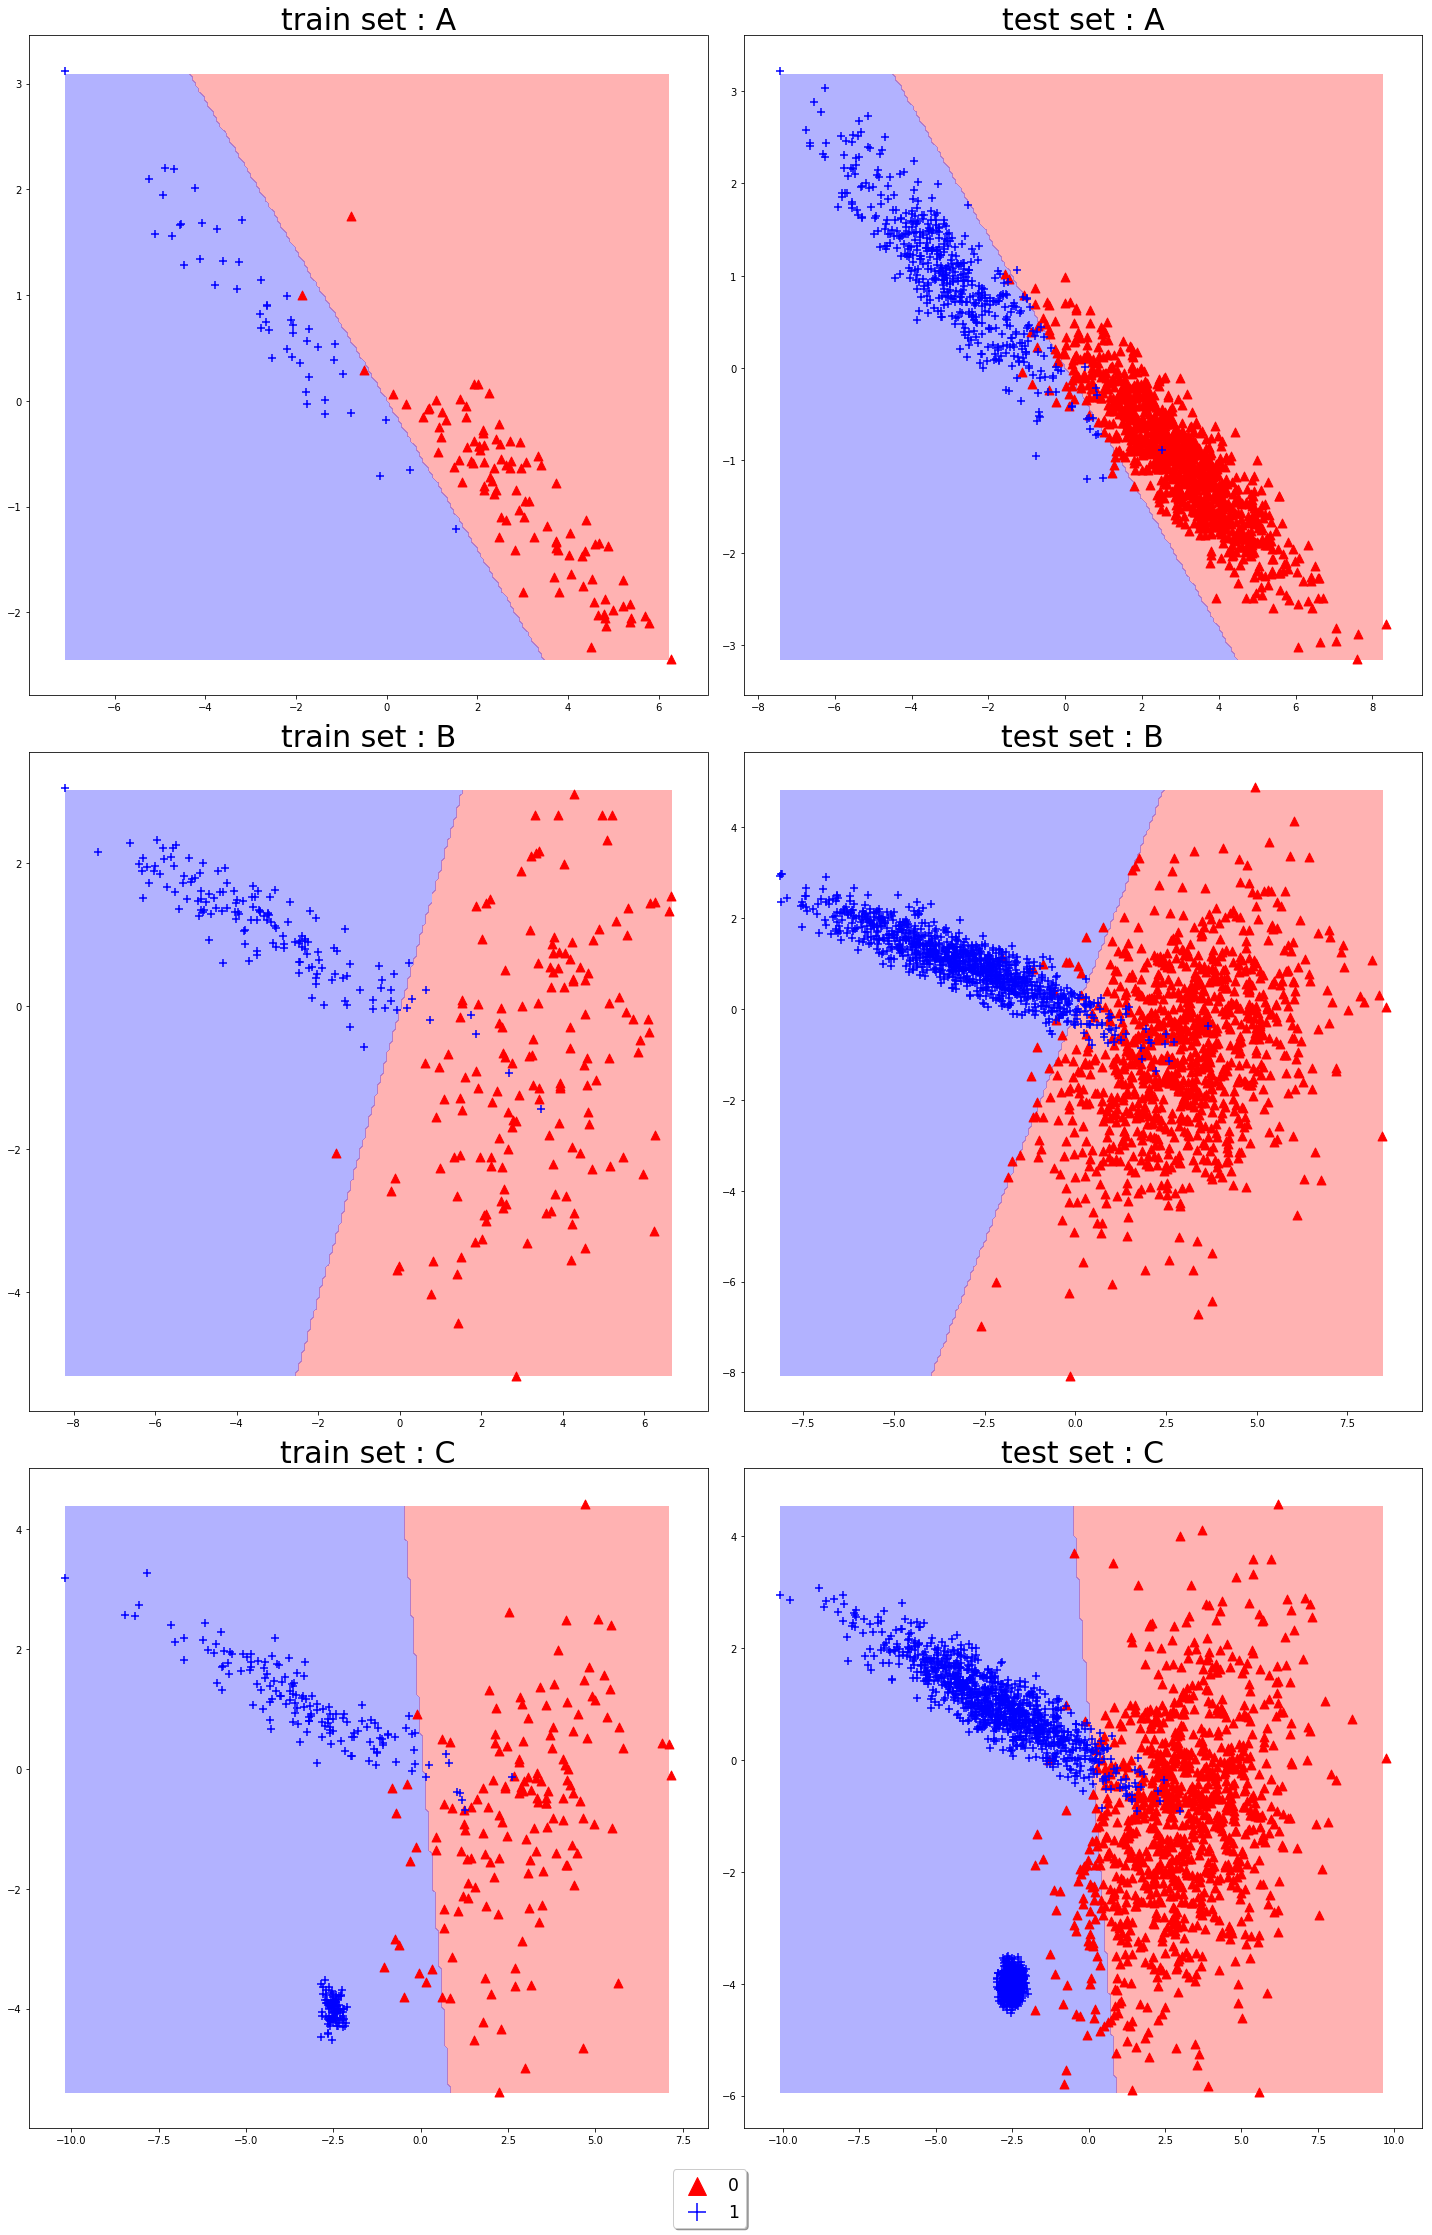

In [20]:
f, ax = plt.subplots(3, 2, figsize = (20, 30))

for k, l in enumerate("ABC"):
    classifier = LDA()
    for j, t in enumerate(["train", "test"]):
        x = D[l][t].as_matrix()[:, :2]
        y = D[l][t].as_matrix()[:, 2]
        # Fit the classifier
        if t == "train":
            classifier.fit(x, y)
        grid, x_grid, y_grid = make_grid(data = x, step = 200)
        ax[k][j].contourf(x_grid, y_grid, classifier.predict(grid).reshape(x_grid.shape),
                          colors = ('red', 'blue'), levels = [-1,0,1], alpha = 0.3)
        for i, label in enumerate([0, 1]):
            ax[k][j].scatter(x[y == label, 0], x[y == label, 1],
                             c = COLS[i], marker = MARKS[i], s = 80, label = label)
            ax[k][j].set_title(t + " set : " + l, size = 30);
        print ("Error in {} : {}".format(t, 1 - classifier.score(x, y)))
    print ("pi : {}".format(classifier.pi))
    print ("mu_0 : {}".format(classifier.mu_0))
    print ("mu_1 : {}".format(classifier.mu_1))
    print ("sigma : {}".format(classifier.sigma))
        
ax[k][j].legend(loc='upper center', bbox_to_anchor=(-0.05, -0.05),
                fancybox=True, shadow=True, ncol=1, fontsize = 'xx-large',
                markerscale = 2)
                
f.tight_layout();

## For logistic regression

/home/vmatthys/.local/lib/python3.5/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/home/vmatthys/.local/lib/python3.5/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log


Classifieur for A training set
[[ -593.91018429]
 [-1028.89425413]
 [  -98.59819979]]
0.966
Log-likelihood -inf
Classifieur for B training set
[[-1.70518586]
 [ 1.02378538]
 [ 1.34959157]]
0.957
Log-likelihood -12612380.742073128
Classifieur for C training set
[[-2.2032324 ]
 [ 0.70926562]
 [ 0.95918885]]
0.977333333333
Log-likelihood -25545735.472984627


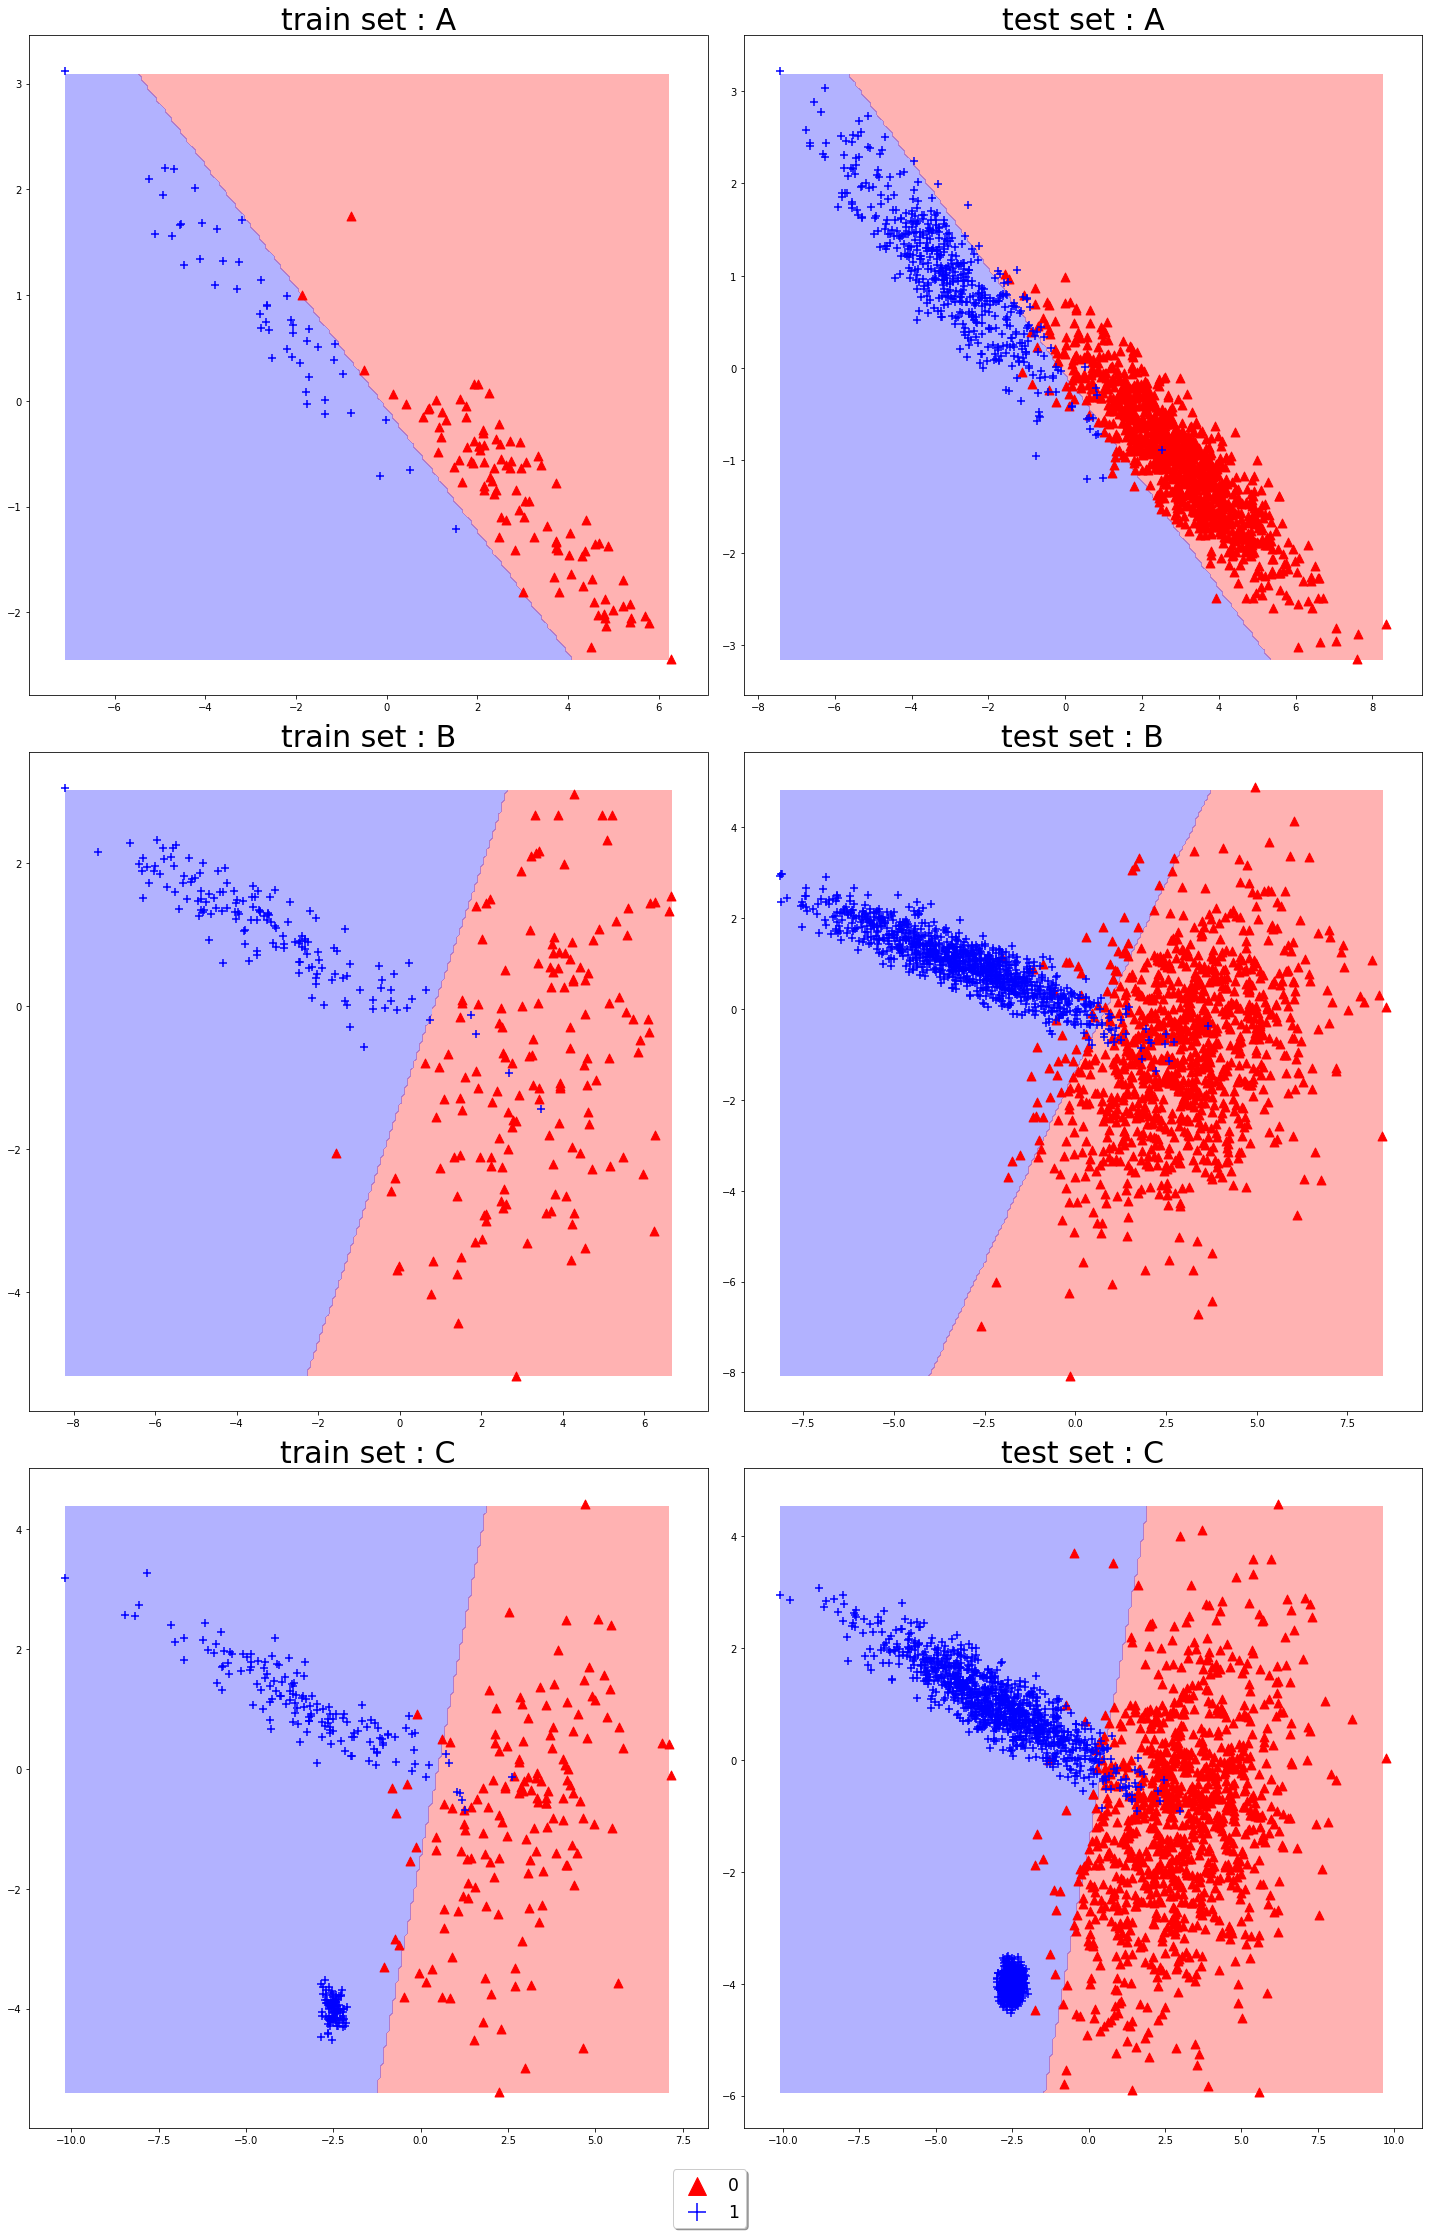

In [14]:
f, ax = plt.subplots(3, 2, figsize = (20, 30))

for k, l in enumerate("ABC"):
    classifier = Logistic_reg()
    for j, t in enumerate(["train", "test"]):
        x = D[l][t].as_matrix()[:, :2]
        y = D[l][t].as_matrix()[:, 2]
        # Fit the classifier
        if t == "train":
            classifier.fit(x, y)
        grid, x_grid, y_grid = make_grid(data = x, step = 200)
        ax[k][j].contourf(x_grid, y_grid, classifier.predict(grid).reshape(x_grid.shape),
                          colors = ('red', 'blue'), levels = [-1,0,1], alpha = 0.3)
        for i, label in enumerate([0, 1]):
            ax[k][j].scatter(x[y == label, 0], x[y == label, 1],
                             c = COLS[i], marker = MARKS[i], s = 80, label = label)
            ax[k][j].set_title(t + " set : " + l, size = 30);
        print ("")
    print ("Classifieur for {} training set".format(l))
    print (classifier.w)
#     print (classifier.score(x, y))
    print ("Log-likelihood {}".format(classifier.log_likelihood(x, y)))
            
ax[k][j].legend(loc='upper center', bbox_to_anchor=(-0.05, -0.05),
                fancybox=True, shadow=True, ncol=1, fontsize = 'xx-large',
                markerscale = 2)
                
f.tight_layout();

## For Linear Regression

w : [[-0.2640075 ]
 [-0.37259311]
 [ 0.49229204]]
sigma_squared : 0.039865517973029736
w : [[-0.10424575]
 [ 0.05179118]
 [ 0.50005043]]
sigma_squared : 0.05426408268952253
w : [[-0.12769333]
 [-0.01700142]
 [ 0.50839982]]
sigma_squared : 0.06224998093748647


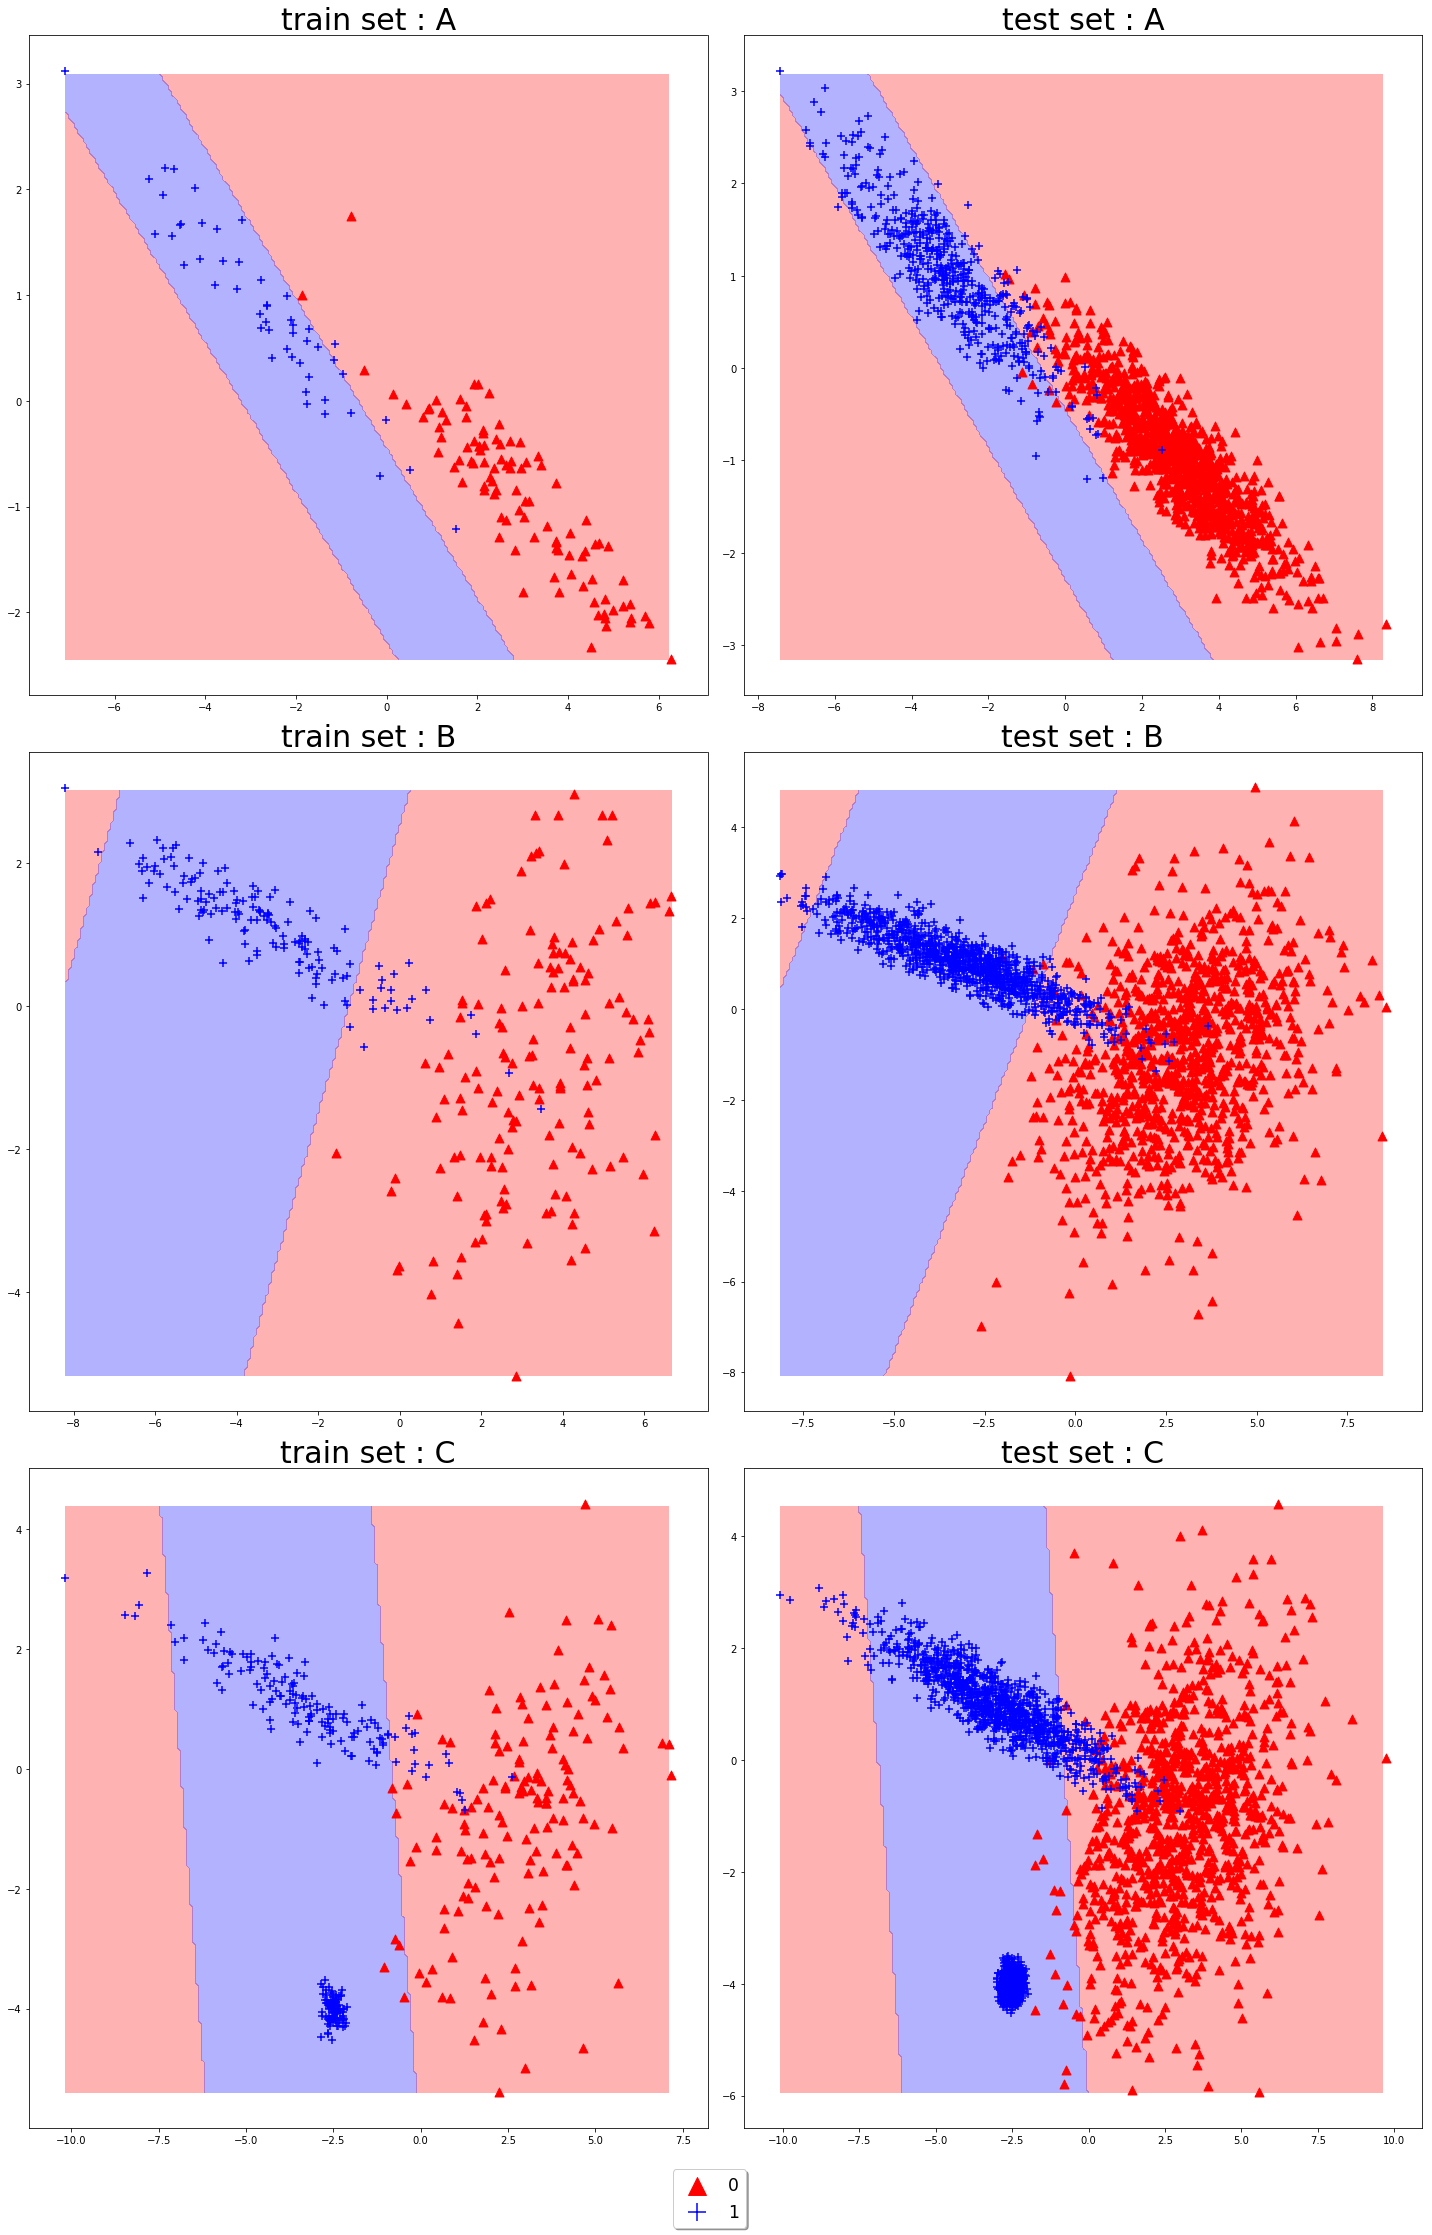

In [18]:
f, ax = plt.subplots(3, 2, figsize = (20, 30))

for k, l in enumerate("ABC"):
    classifier = Linear_reg()
    for j, t in enumerate(["train", "test"]):
        x = D[l][t].as_matrix()[:, :2]
        y = D[l][t].as_matrix()[:, 2]
        # Fit the classifier
        if t == "train":
            classifier.fit(x, y)
        grid, x_grid, y_grid = make_grid(data = x, step = 200)
        ax[k][j].contourf(x_grid, y_grid, classifier.predict(grid).reshape(x_grid.shape),
                          colors = ('red', 'blue'), levels = [-1,0,1], alpha = 0.3)
        for i, label in enumerate([0, 1]):
            ax[k][j].scatter(x[y == label, 0], x[y == label, 1],
                             c = COLS[i], marker = MARKS[i], s = 80, label = label)
            ax[k][j].set_title(t + " set : " + l, size = 30);

    print ("w : {}".format(classifier.w))
    print ("sigma_squared : {}".format(classifier.sigma_square))

ax[k][j].legend(loc='upper center', bbox_to_anchor=(-0.05, -0.05),
                fancybox=True, shadow=True, ncol=1, fontsize = 'xx-large',
                markerscale = 2)
                
f.tight_layout();

## QDA

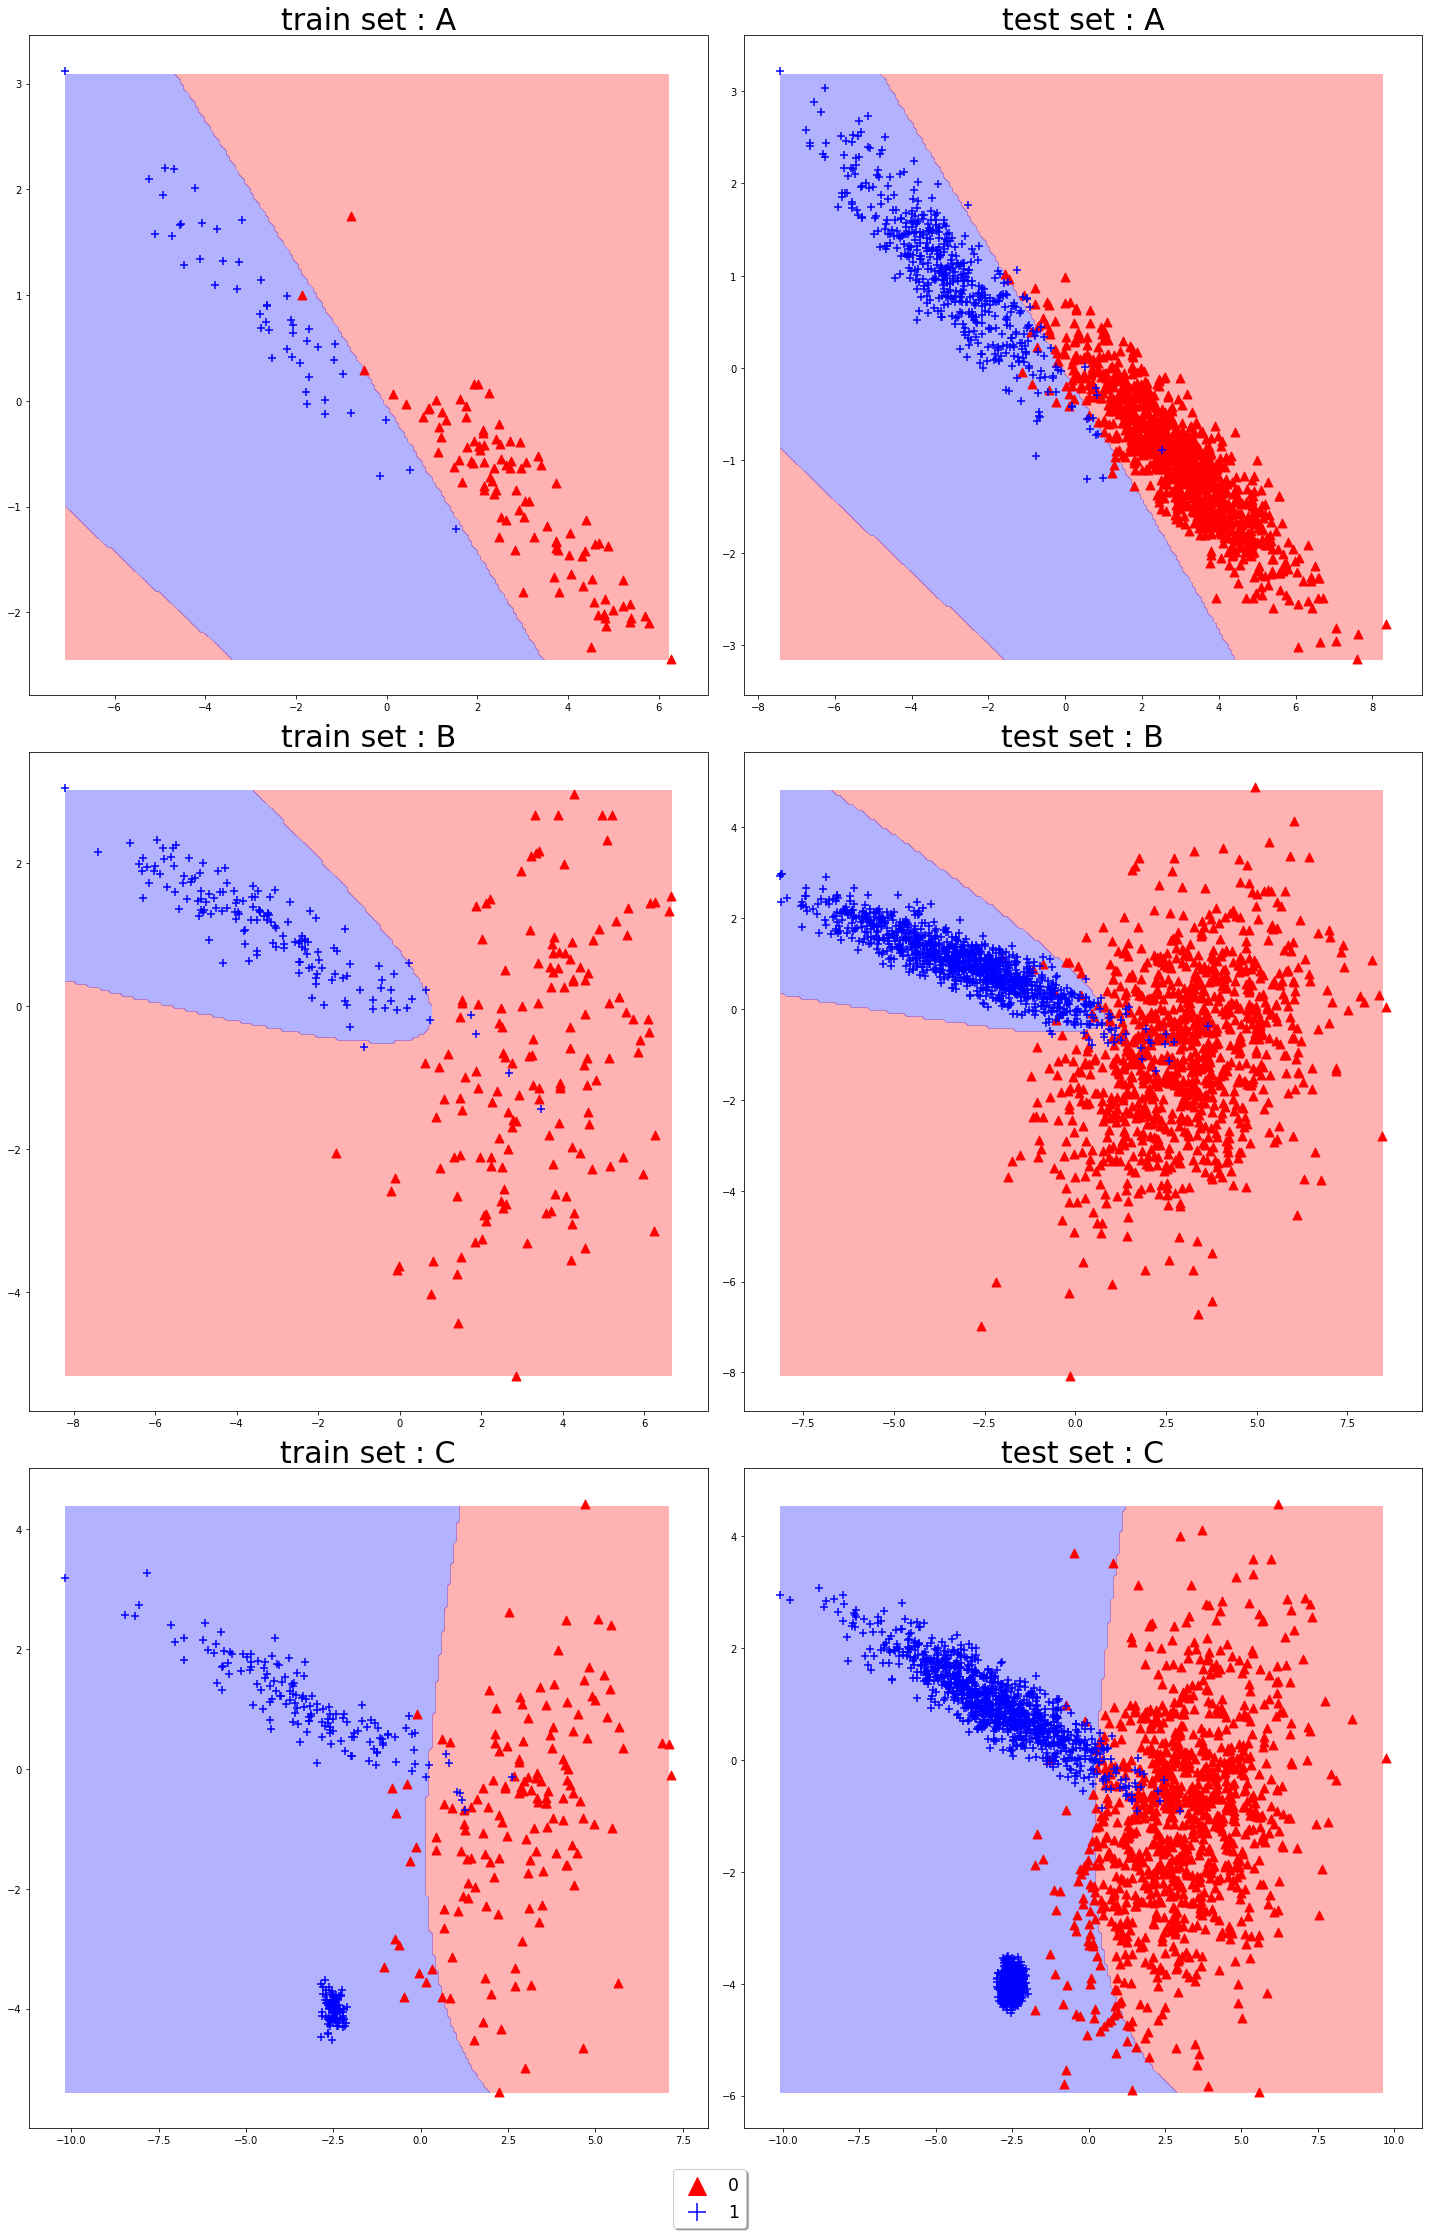

In [16]:
f, ax = plt.subplots(3, 2, figsize = (20, 30))

for k, l in enumerate("ABC"):
    classifier = QDA()
    for j, t in enumerate(["train", "test"]):
        x = D[l][t].as_matrix()[:, :2]
        y = D[l][t].as_matrix()[:, 2]
        # Fit the classifier
        if t == "train":
            classifier.fit(x, y)
        grid, x_grid, y_grid = make_grid(data = x, step = 200)
        ax[k][j].contourf(x_grid, y_grid, classifier.predict(grid).reshape(x_grid.shape),
                          colors = ('red', 'blue'), levels = [-1,0,1], alpha = 0.3)
        for i, label in enumerate([0, 1]):
            ax[k][j].scatter(x[y == label, 0], x[y == label, 1],
                             c = COLS[i], marker = MARKS[i], s = 80, label = label)
            ax[k][j].set_title(t + " set : " + l, size = 30);

            
ax[k][j].legend(loc='upper center', bbox_to_anchor=(-0.05, -0.05),
                fancybox=True, shadow=True, ncol=1, fontsize = 'xx-large',
                markerscale = 2)
                
f.tight_layout();

# Test zone

In [12]:
Xtrain, Ytrain = D['A']['train'].as_matrix()[:, :2], D['A']['train'].as_matrix()[:, 2]
Xtest, Ytest = D['A']['test'].as_matrix()[:, :2], D['A']['test'].as_matrix()[:, 2]

In [13]:
D['A']['train'].as_matrix()

array([[-3.60340505,  1.3266    ,  1.        ],
       [-4.2190114 ,  2.015     ,  1.        ],
       [-1.51565812,  0.5059    ,  1.        ],
       [-1.16975695,  0.3815    ,  1.        ],
       [ 0.52274116, -0.6572    ,  1.        ],
       [-0.14174035, -0.7083    ,  1.        ],
       [-3.2644966 ,  1.312     ,  1.        ],
       [-1.7093627 ,  0.2236    ,  1.        ],
       [-2.06451872,  0.6392    ,  1.        ],
       [-2.7745778 ,  1.139     ,  1.        ],
       [-4.4637327 ,  1.2861    ,  1.        ],
       [-2.05557939,  0.716     ,  1.        ],
       [-4.93081485,  1.9442    ,  1.        ],
       [-2.78573378,  0.8165    ,  1.        ],
       [-3.78492412,  1.0945    ,  1.        ],
       [-0.023503  , -0.1801    ,  1.        ],
       [-4.0787268 ,  1.6789    ,  1.        ],
       [-4.88879174,  2.2006    ,  1.        ],
       [-4.11260798,  1.3405    ,  1.        ],
       [-5.11303227,  1.578     ,  1.        ],
       [-2.76271871,  0.6868    ,  1.   

In [21]:
lda = LDA()
lda.fit(Xtrain, Ytrain)
lda.score(Xtrain, Ytrain)

0.98666666666666669

## Logistic regression

In [169]:
w = np.random.random((3,1))
w

array([[ 0.54809642],
       [ 0.07140802],
       [ 0.2805465 ]])

In [182]:
def Snd_term(w, datax, datay):
    D = np.diagflat(sigmoid(w, datax) * (1 - sigmoid(w, datax)))
    L = np.dot(np.dot(datax.T, D), datax)
    L_inv = np.linalg.inv(L)
    LL = np.dot(L_inv, datax.T)
    return np.dot(LL, (Ytrain.reshape(-1 ,1) - sigmoid(w, datax)))

In [191]:
w2 = w + Snd_term(w, Xt, Ytrain)
w2

array([[-1.98086279],
       [-0.27081074],
       [-0.87289311]])

In [192]:
w3 = w2 + Snd_term(w2, Xt, Ytrain)
w3

array([[-2.9166458 ],
       [-3.8151922 ],
       [-0.22647962]])

In [193]:
w4 = w3 + Snd_term(w3, Xt, Ytrain)
w4

array([[-4.40169656],
       [-6.81741635],
       [-0.50531969]])

In [194]:
w5 = w4 + Snd_term(w4, Xt, Ytrain)
w5

array([[ -6.31887571],
       [-10.30994101],
       [ -0.90942126]])

In [195]:
w6 = w5 + Snd_term(w5, Xt, Ytrain)
w6

array([[ -8.91910163],
       [-14.81812404],
       [ -1.50414101]])

In [203]:
w = np.random.random((3, 1))
print (w)
for i in range(100):
    w += Snd_term(w, Xt, Ytrain)

[[ 0.56035882]
 [ 0.86880299]
 [ 0.03325499]]


/home/vmatthys/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  


In [204]:
w

array([[-1431.31571334],
       [-2482.78001986],
       [ -250.73340788]])

In [202]:
w

array([[-1468.32011274],
       [-2540.02547296],
       [ -258.30598867]])

In [200]:
w

array([[-1407.5403025 ],
       [-2428.59923508],
       [ -246.82841348]])

In [208]:
sigmoid(w, Xt)

/home/vmatthys/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  


array([[  1.00000000e+000],
       [  1.00000000e+000],
       [  1.00000000e+000],
       [  1.00000000e+000],
       [  1.00000000e+000],
       [  1.00000000e+000],
       [  1.00000000e+000],
       [  1.00000000e+000],
       [  1.00000000e+000],
       [  1.00000000e+000],
       [  1.00000000e+000],
       [  1.00000000e+000],
       [  1.00000000e+000],
       [  1.00000000e+000],
       [  1.00000000e+000],
       [  1.00000000e+000],
       [  1.00000000e+000],
       [  1.00000000e+000],
       [  1.00000000e+000],
       [  1.00000000e+000],
       [  1.00000000e+000],
       [  1.00000000e+000],
       [  1.00000000e+000],
       [  1.00000000e+000],
       [  1.00000000e+000],
       [  1.00000000e+000],
       [  1.00000000e+000],
       [  1.00000000e+000],
       [  1.00000000e+000],
       [  1.00000000e+000],
       [  1.00000000e+000],
       [  1.00000000e+000],
       [  1.00000000e+000],
       [  1.00000000e+000],
       [  1.00000000e+000],
       [  1.00000000

In [295]:
lr.w

array([[-1432.54996031],
       [-2485.70755695],
       [ -251.04011323]])

In [296]:
lr.w / (251 / 1.538)

array([[ -8.77793561],
       [-15.2311483 ],
       [ -1.53824579]])

In [313]:
lr.w

array([[-1465.63431308],
       [-2533.98461134],
       [ -260.62974253]])

In [331]:
lr = Logistic_reg()
lr.fit(Xtrain, Ytrain)

array([[-0.57522423],
       [-0.81799578],
       [-0.08429993]])

In [265]:
lr.w

array([[ -8.80104963],
       [-14.61280768],
       [ -1.53855785]])

In [261]:
lr.w

array([[ -8.13375852],
       [-13.47796936],
       [ -1.35772367]])

In [263]:
lr.w

array([[ -8.80104963],
       [-14.61280768],
       [ -1.53855785]])

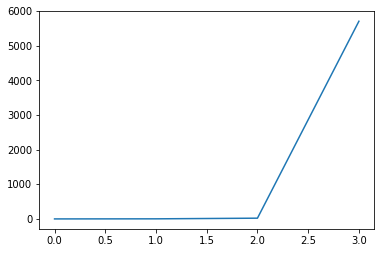

In [143]:
plt.plot(np.linalg.norm(lr.w_histo, axis = 0));

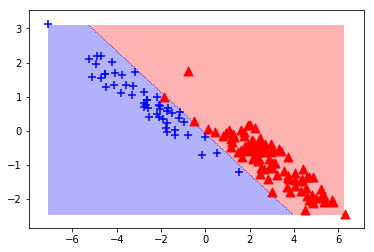

In [260]:
grid, x_grid, y_grid = make_grid(data = Xtrain, step = 200)
plt.contourf(x_grid, y_grid, lr.predict(grid).reshape(x_grid.shape),
                          colors = ('red', 'blue'), levels = [-1,0,1], alpha = 0.3)
for i, label in enumerate([0, 1]):
    plt.scatter(Xtrain[Ytrain == label, 0], Xtrain[Ytrain == label, 1],
                     c = COLS[i], marker = MARKS[i], s = 80, label = label)

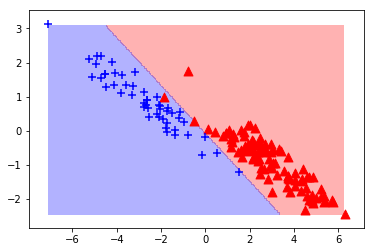

In [586]:
grid, x_grid, y_grid = make_grid(data = Xtrain, step = 200)
plt.contourf(x_grid, y_grid, lr.predict(grid).reshape(x_grid.shape),
                          colors = ('red', 'blue'), levels = [-1,0,1], alpha = 0.3)
for i, label in enumerate([0, 1]):
    plt.scatter(Xtrain[Ytrain == label, 0], Xtrain[Ytrain == label, 1],
                     c = COLS[i], marker = MARKS[i], s = 80, label = label)

In [587]:
clf.w

array([[ 1.48820326],
       [ 1.7433016 ],
       [-0.36158701]])

# IRLS not converging

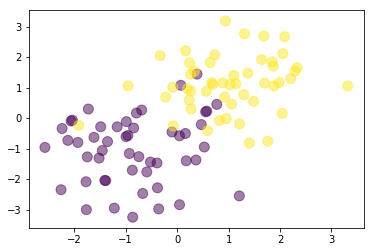

In [541]:
import numpy as np
import matplotlib.pyplot as plt

N = 100
D = 2

X = np.random.randn(N,D)

# center the first 50 points at (-1,-1)
X[:50,:] = X[:50,:] - np.ones((50,D))

# center the last 50 points at (1, 1)
X[50:,:] = X[50:,:] + np.ones((50,D))

# labels: first 50 are 0, last 50 are 1
T = np.array([0]*50 + [1]*50)

# add a column of ones
ones = np.array([[1]*N]).T
Xb = np.concatenate((ones, X), axis=1)

# randomly initialize the weights
w = np.zeros(D + 1)

plt.scatter(X[:,0], X[:,1], c=T, s=100, alpha=0.5)

plt.show()

In [542]:
beta_temp = np.random.randn(D + 1)
# numpy version
def np_sigmoid(mu):
    return np.exp(mu) / (1 + np.exp(mu))

for i in range(10):
    # updating Weight matrix
    npphat = np_sigmoid(Xb.dot(beta_temp))
    np_wi = npphat * (1- npphat)
    npWinv = np.diag(np_wi)

    #updating beta
    np_z = Xb.dot(beta_temp) + (T - npphat) / np_wi
    beta_temp = np.linalg.inv((Xb.T).dot(npWinv).dot(Xb)).dot(Xb.T).dot(npWinv).dot(np_z)
    print ("numpy beta:", beta_temp)

numpy beta: [-0.27456245  1.1983274   1.280425  ]
numpy beta: [-0.32838704  1.40485748  1.61236238]
numpy beta: [-0.35802931  1.48056069  1.73173834]
numpy beta: [-0.36155338  1.48813755  1.74320724]
numpy beta: [-0.361587    1.48820325  1.74330159]
numpy beta: [-0.36158701  1.48820326  1.7433016 ]
numpy beta: [-0.36158701  1.48820326  1.7433016 ]
numpy beta: [-0.36158701  1.48820326  1.7433016 ]
numpy beta: [-0.36158701  1.48820326  1.7433016 ]
numpy beta: [-0.36158701  1.48820326  1.7433016 ]


[-0.36158701  1.48820326  1.7433016 ]


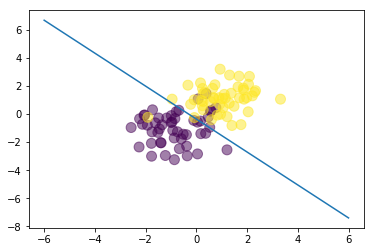

In [543]:
plt.scatter(Xb[:,1], Xb[:,2], c=T, s=100, alpha=0.5)

x_axis = np.linspace(-6, 6, 100)
beta_value = beta_temp
print (beta_value)
y_axis = beta_value[0] + x_axis*(-beta_value[2] / beta_value[1])
plt.plot(x_axis, y_axis)
plt.show()

In [544]:
beta_value

array([-0.36158701,  1.48820326,  1.7433016 ])

[[ 1.48820326]
 [ 1.7433016 ]
 [-0.36158701]]


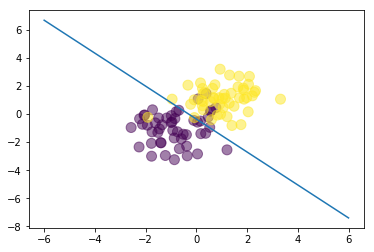

In [550]:
plt.scatter(Xb[:,1], Xb[:,2], c=T, s=100, alpha=0.5)
clf = Logistic_reg()
clf.fit(X, T)
x_axis = np.linspace(-6, 6, 100)
beta_value = clf.w
print (beta_value)
y_axis = beta_value[2] + x_axis*(-beta_value[1] / beta_value[0])
plt.plot(x_axis, y_axis)
plt.show()

[[-0.36158701]
 [ 1.7433016 ]
 [-0.36158701]]


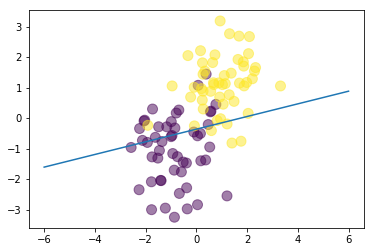

In [546]:
plt.scatter(Xb[:,1], Xb[:,2], c=T, s=100, alpha=0.5)
clf = Logistic_reg()
clf.fit(X, T)
x_axis = np.linspace(-6, 6, 100)
tmp = clf.w[0]
clf.w[0] = clf.w[2]
clf.w[2] = tmp
beta_value = clf.w
print (beta_value)
y_axis = beta_value[0] + x_axis*(-beta_value[2] / beta_value[1])
plt.plot(x_axis, y_axis)
plt.show()

In [551]:
Xtrain

array([[-3.60340505,  1.3266    ],
       [-4.2190114 ,  2.015     ],
       [-1.51565812,  0.5059    ],
       [-1.16975695,  0.3815    ],
       [ 0.52274116, -0.6572    ],
       [-0.14174035, -0.7083    ],
       [-3.2644966 ,  1.312     ],
       [-1.7093627 ,  0.2236    ],
       [-2.06451872,  0.6392    ],
       [-2.7745778 ,  1.139     ],
       [-4.4637327 ,  1.2861    ],
       [-2.05557939,  0.716     ],
       [-4.93081485,  1.9442    ],
       [-2.78573378,  0.8165    ],
       [-3.78492412,  1.0945    ],
       [-0.023503  , -0.1801    ],
       [-4.0787268 ,  1.6789    ],
       [-4.88879174,  2.2006    ],
       [-4.11260798,  1.3405    ],
       [-5.11303227,  1.578     ],
       [-2.76271871,  0.6868    ],
       [-7.08295715,  3.1183    ],
       [-2.10955767,  0.7613    ],
       [-0.77900674, -0.1129    ],
       [-4.72843487,  1.5547    ],
       [-2.63444768,  0.8987    ],
       [-4.5475173 ,  1.6635    ],
       [-2.20077236,  0.4904    ],
       [-2.53362889,